In [6]:
# Read and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Feature Extract
from instapred_bot.prediction_part.tokenizer import text_transform
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy
import nltk
nltk.download('punkt')

# Models fit
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.model_selection import learning_curve

# Export
import pickle

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 9

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


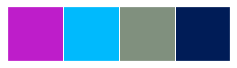

In [7]:
sns.set(rc={'figure.figsize':(15,9)})
colors = ['#BE1DCA', '#00BAFD', '#80907e', '#001c57']
sns.palplot(sns.color_palette(colors))

# 1. Read Data

In [8]:
df = pd.read_csv('data/data.csv')

# 2. Explore

In [9]:
df.describe()

,likes4post,comms4post,hashtags4post,lenth_title4post,publications_period,count_posts,count_followers,count_followees,count_igtv
count,2.534000e+03,2534.000000,2534.000000,2534.000000,2190.000000,2534.000000,2.534000e+03,2534.000000,2534.000000
mean,3.688496e+03,24.931481,2.535277,278.500041,963.262100,377.490134,4.132164e+04,1097.667324,37.079716
std,1.588094e+05,636.351768,5.699884,358.338616,2753.216031,950.622274,1.293301e+06,1700.303994,114.452868
min,-1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,1.002500e+01,0.200000,0.000000,7.725000,75.000000,17.000000,3.500000e+02,139.000000,0.000000
50%,4.280000e+01,1.366667,0.000000,120.200000,218.500000,81.000000,1.096000e+03,387.000000,3.000000
75%,1.236500e+02,5.000000,1.600000,442.900000,828.000000,358.000000,5.449750e+03,1099.750000,23.750000
max,7.992839e+06,31829.800000,34.000000,2162.300000,41044.000000,22705.000000,6.495082e+07,7509.000000,1989.000000


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2534 entries, 0 to 2533
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_name            2534 non-null   object 
 1   is_business          2534 non-null   bool   
 2   is_private           2534 non-null   bool   
 3   post_captions        2078 non-null   object 
 4   likes4post           2534 non-null   float64
 5   comms4post           2534 non-null   float64
 6   hashtags4post        2534 non-null   float64
 7   lenth_title4post     2534 non-null   float64
 8   publications_period  2190 non-null   float64
 9   count_posts          2534 non-null   float64
 10  count_followers      2534 non-null   float64
 11  count_followees      2534 non-null   float64
 12  count_igtv           2534 non-null   float64
 13  is_verified          2534 non-null   bool   
 14  biography            2023 non-null   object 
 15  full_name            2341 non-null   o

In [11]:
df.replace(to_replace=True, value=1, inplace=True)
df.replace(to_replace=False, value=0, inplace=True)

## 2.1. Fill NA

In [12]:
df.post_captions.fillna('', inplace=True)
df.biography.fillna('', inplace=True)
df.full_name.fillna('', inplace=True)
df.publications_period.fillna(0, inplace=True)

In [13]:
cat_feats = list(df.drop('target', axis=1).dtypes[df.dtypes == 'int64'].index)
text_feats = list(df.dtypes[df.dtypes == 'object'].index)
num_feats = list(df.dtypes[df.dtypes == 'float64'].index)

cat_feats.append(text_feats.pop(4))

## 2.2. Target

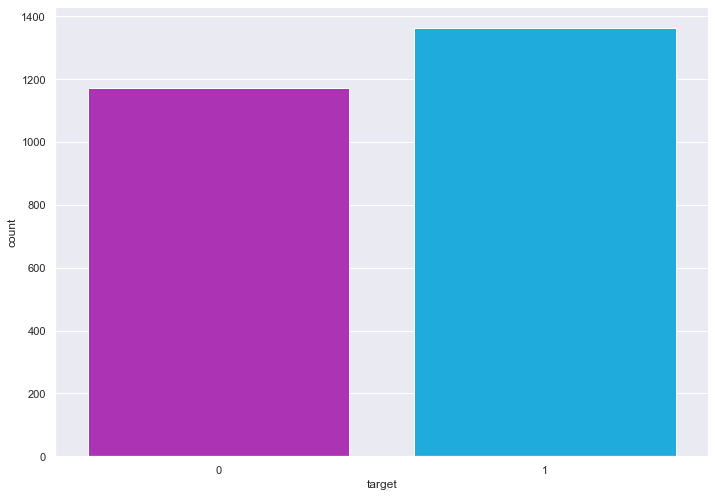

In [14]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.countplot(df.target, palette=colors);

**We have a little bit target imbalance. Anyway we're gonna use F1 score which is not affected by the imbalance.**

Налюдается небольшой дисбаланс целевой переменной. Однако мы будем использовать метрику F1 score, которая устойчива к дисбалансу.

## 2.3. Numeric Feats

In [15]:
# add one more num feat
df['len_bio'] = df.biography.apply(lambda x: len(x)).astype('float')
num_feats.append('len_bio')

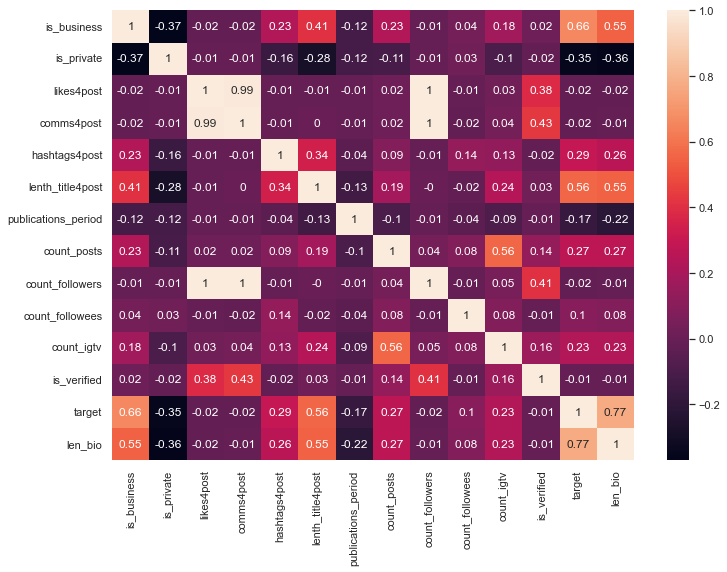

In [16]:
sns.heatmap(df.corr().round(2), annot=True);

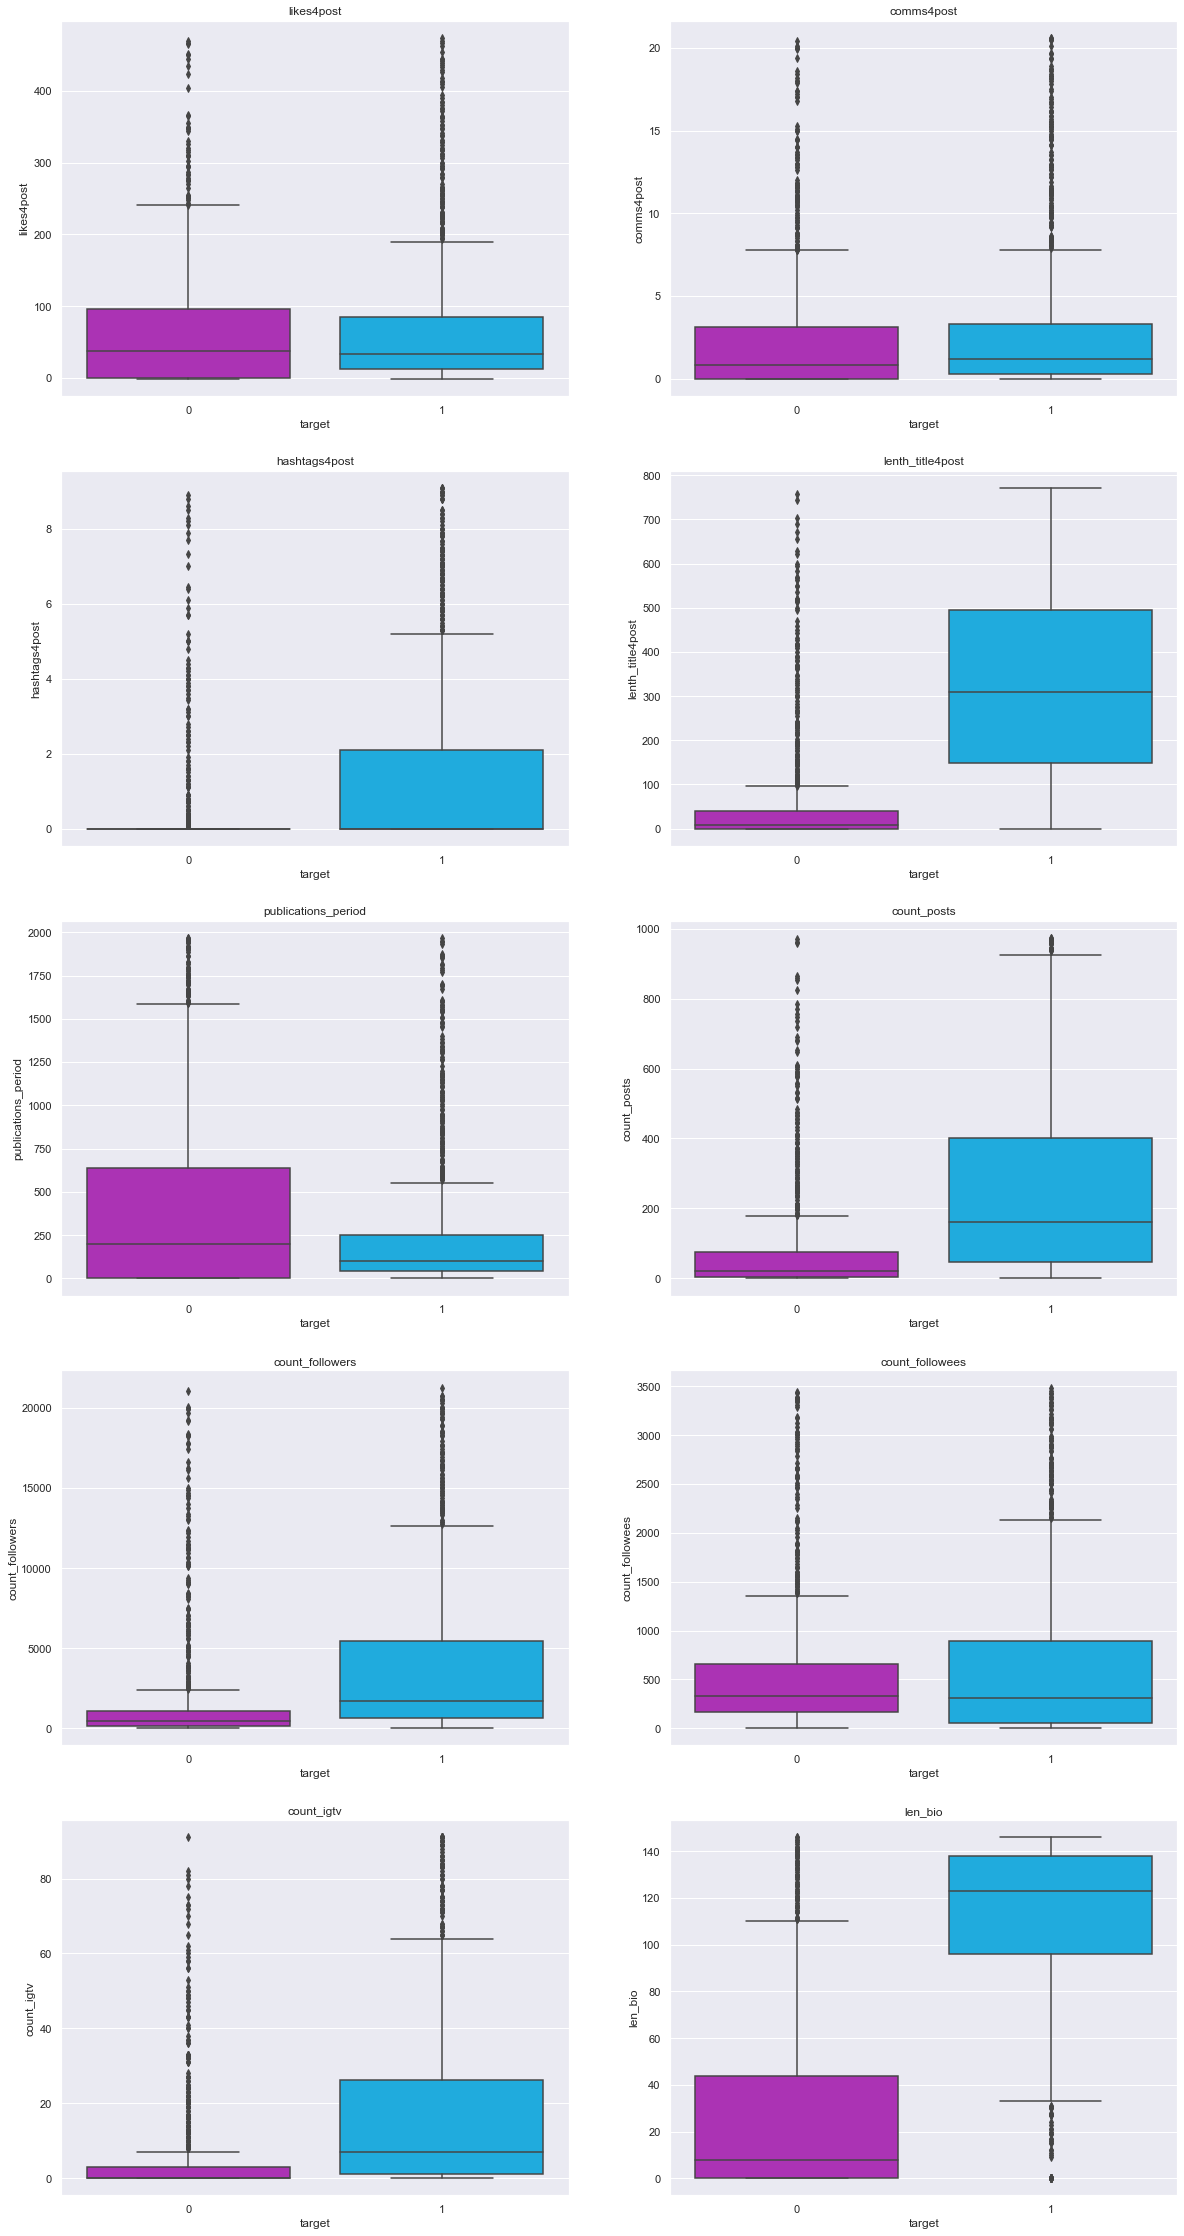

In [17]:
fig, axs = plt.subplots(5, 2, figsize=(20, 40))
for i, ax in enumerate(axs.reshape(-1)):
    sns.boxplot(df.target, df.loc[df[num_feats[i]] < df[num_feats[i]].quantile(0.9), num_feats[i]], ax=ax, palette=colors).set_title(num_feats[i]);

**It can be seen from the boxplots that the sample has a lot of outliers, cause the dependent selection of observations from the total populationn. However our models are resistant to outliers (RandomForest and XGBoost). Also, the sample is small and the removal of outliers is more likely to lead to a deterioration in the quality of the prediction. Therefore, there will be no cleaning from emissions.**  
  
  **From the correlation matrix, you can notice the multicollinearity of 3 features: comms4post, likes4post and count_followers. These features intuitively should have a correlation. However, such a strong correlation is due to a large number of outliers. Moreover, if you remove any 2 signs, the prediction quality also decreases, so these features will be left.**


Из графиков видно, что выборка имеет много выбросов, это обусловлено зависимым выборов наблюдений из генеральной совокупоности. Однако модели, которые предполается использовать, устойчивы к выбросам (RandomForest и XGBoost). Также выборка небольшая и удаление выбросов скорее приведет к ухудшению качества предсказания. Поэтому очистки от выбросов производиться не будет.   
  
Из матрицы корреляций видна мультиколлинеарность 3-х признаков: среднее количество комментариев к посту, среднее количество лайков на посте и количество подписчиков. Эти признаки действительно интуитивно должны иметь корреляцию. Однако такая сильная корреляция обусловлено большим количеством выбросов. И при удалении любых 2-х признаков качество предсказания также снижается, поэтому эти фичи будут оставлены.

## 2.4. Cat Feats

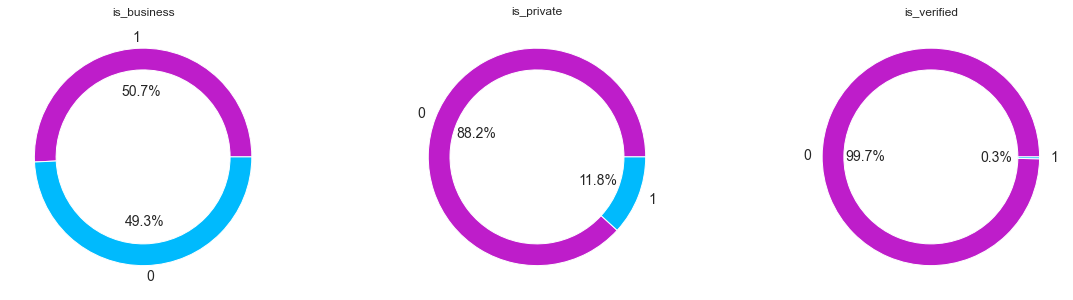

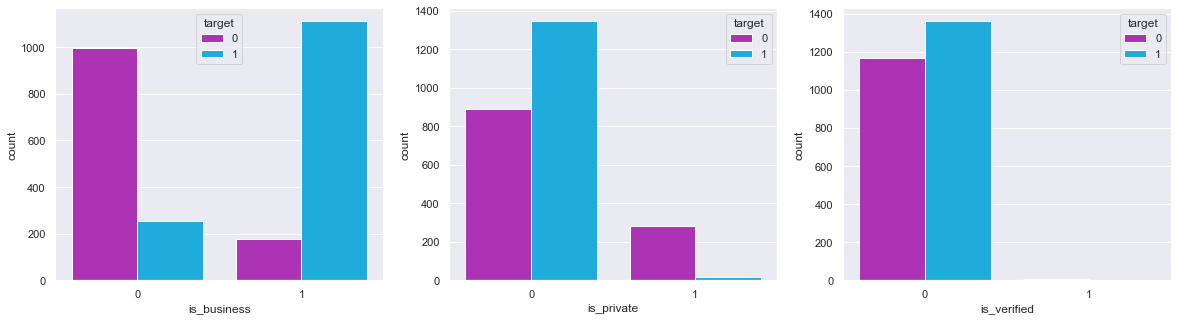

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
for i, ax in enumerate(axs.reshape(-1)):
    ax.pie(df[cat_feats[i]].value_counts(), colors=colors, labels=df[cat_feats[i]].value_counts().index, textprops={'fontsize': 14}, autopct='%1.1f%%', wedgeprops=dict(width=0.2))
    ax.set(aspect='equal', title=cat_feats[i])
    
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
for i, ax in enumerate(axs.reshape(-1)):
    sns.countplot(df[cat_feats[i]], ax=ax, hue=df.target, palette=colors)

In [19]:
bus_cat = pd.DataFrame(df.groupby(['business_category'], as_index=True).agg({'target': 'mean', 'is_business': 'count'}))
bus_cat = bus_cat.rename(columns={'is_business': 'count'}).sort_values('count', ascending=False)
bus_cat

,target,count
business_category,,
Personal Goods & General Merchandise Stores,0.983425,543
Creators & Celebrities,0.612245,343
0,0.052083,192
Restaurants,0.974684,79
Lifestyle Services,0.947368,76
General Interest,0.716981,53
Professional Services,0.916667,36
Home Goods Stores,1.000000,32
Home Services,0.884615,26


**The is_verified feature should be removed, because it doesn't provide additional qualitative information to the models.**  
**Group the values of business_category, the number of which is less than 10, into the value 'Other'**

Признак is_verified следует удалить, так как он не дает моделям дополнительной качественной информации.  
Сгруппируем значения business_category, количество которых меньше 10,  в значение 'Other'

In [20]:
df.drop('is_verified', axis=1, inplace=True)

In [21]:
other_idx = bus_cat[bus_cat['count'] < 10].index
df.loc[df.business_category.isin(other_idx), 'business_category'] = 'Other'

In [22]:
# One Hot Encoding
df = pd.get_dummies(df, columns=['business_category']) 

In [23]:
# create df mask to prediction part
df_zero = pd.DataFrame(columns=df.columns)
df_zero.drop('target', axis=1).to_csv('data_zero.csv', index=False)

# 3. Feature Ecstractor

In [24]:
X, y = df.drop('target', axis=1), df.target

In [25]:
# split words in user names
X['user_name'] = X.user_name.apply(lambda x: re.sub('[_.]', ' ', x))

In [26]:
# initialization TFIDF
tfidf_user_names = TfidfVectorizer(min_df=5)
tfidf_posts = TfidfVectorizer(tokenizer=text_transform, min_df=20, max_df=100)
tfidf_bios = TfidfVectorizer(tokenizer=text_transform, min_df=5)
tfidf_full_name = TfidfVectorizer(min_df=5)

In [28]:
# transform
user_names = tfidf_user_names.fit_transform(X.user_name)
posts = tfidf_posts.fit_transform(X.post_captions)
bios = tfidf_bios.fit_transform(X.biography)
full_names = tfidf_full_name.fit_transform(X.full_name)

In [29]:
print('Len user names vocabulary:', len(tfidf_user_names.vocabulary_))
print('Len posts vocabulary :', len(tfidf_posts.vocabulary_))
print('Len biography vocabulary  :', len(tfidf_bios.vocabulary_))
print('Len full names vocabulary  :', len(tfidf_full_name.vocabulary_))

Len user names vocabulary: 85
Len posts vocabulary : 2608
Len biography vocabulary  : 798
Len full names vocabulary  : 186


In [30]:
# Concat data
X_new = scipy.sparse.hstack([X.drop(['post_captions', 'full_name', 'biography', 'user_name'], axis=1), 
                                    user_names, posts, bios, full_names])

In [31]:
X_new.shape

(2534, 3703)

# 4. Models Fit

In [32]:
X_tr, X_test, y_tr, y_test = train_test_split(X_new, y, test_size=0.25, random_state=RANDOM_STATE)

In [33]:
# score-function
def get_test_scores(y, y_pred):
    print(f'Test: F1: {f1_score(y, y_pred).round(4)} | Prec: {precision_score(y, y_pred).round(4)} | Recall: {f1_score(y, y_pred).round(4)}', '\n')

## 4.1. RF

In [34]:
# forest with default params
forest = RandomForestClassifier(random_state=RANDOM_STATE)

print('Cross Val Score: ', cross_val_score(forest, X_tr, y_tr, cv=5, n_jobs=-1, scoring='f1').mean())

forest.fit(X_tr, y_tr)
rf_pred_val = forest.predict(X_test)

get_test_scores(y_test, rf_pred_val)

Cross Val Score:  0.9462380247332909
Test: F1: 0.9417 | Prec: 0.9556 | Recall: 0.9417 



In [35]:
# search the best params
forest = RandomForestClassifier(random_state=RANDOM_STATE)
params = {'max_depth': range(5, 45, 2),
          'min_samples_split': range(2, 15, 2),
          'min_samples_leaf': range(1, 10, 2),
          'n_estimators': [100]
}

searcher = GridSearchCV(forest, param_grid=params, cv=5, n_jobs=-1, scoring='f1', error_score='raise')
searcher.fit(X_tr, y_tr)

rf_pred_test = searcher.best_estimator_.predict(X_test)

print('Best_params :', searcher.best_params_)
print('Best_score: ', searcher.best_score_)
get_test_scores(y_test, rf_pred_test)


Best_params : {'max_depth': 35, 'min_samples_leaf': 1, 'min_samples_split': 14, 'n_estimators': 100}
Best_score:  0.9486123002304586
Test: F1: 0.9405 | Prec: 0.9501 | Recall: 0.9405 



In [36]:
# try with 1000 estimators
searcher.best_params_['n_estimators'] = 1000
best_forest = RandomForestClassifier(**searcher.best_params_, random_state=RANDOM_STATE)

print('Cross Val Score: ', cross_val_score(best_forest, X_tr, y_tr, cv=5, n_jobs=-1, scoring='f1').mean())

best_forest.fit(X_tr, y_tr)
rf_pred_val = best_forest.predict(X_test)

get_test_scores(y_test, rf_pred_val)

Cross Val Score:  0.9471759381325239
Test: F1: 0.9351 | Prec: 0.9391 | Recall: 0.9351 



In [37]:
# increasing num_estimators doesn't increase the quality of the model
searcher.best_params_['n_estimators'] = 100
best_forest = best_forest = RandomForestClassifier(**searcher.best_params_, random_state=RANDOM_STATE)

## 4.2. XGBoost

In [ ]:
# xgb with default params
xgb_model = xgb.XGBClassifier(verbosity=0)

print('Cross Val Score: ', cross_val_score(xgb_model, X_tr, y_tr, cv=5, n_jobs=-1, scoring='f1').mean())

xgb_model.fit(X_tr, y_tr)
xgb_pred_val = xgb_model.predict(X_test)

get_test_scores(y_test, xgb_pred_val)

Cross Val Score:  0.9439834462596947
Test: F1: 0.9386 | Prec: 0.9554 | Recall: 0.9386 



In [ ]:
#serach the best params
params = {'colsample_bytree': [0.2, 0.4, 0.6, 0.8, 1],
        'learning_rate': np.logspace(-2, 0, 25),
        'max_depth': [2],
        'lambda': np.logspace(-2, 0, 25),
        'alpha': np.logspace(-2, 1, 25),
        'subsample': np.arange(0.2, 0.9, 0.1),
        'n_estimators': [500],
        'gamma': np.logspace(-2, 1, 25),
        'num_rounds': range(10, 1000, 100),
        'verbosity': [0]}

searcher = RandomizedSearchCV(xgb_model, param_distributions=params, cv=5, n_iter=500, n_jobs=-1, verbose=10)
searcher.fit(X_tr, y_tr)

xgb_pred_val = searcher.best_estimator_.predict(X_test)

print('Best_params :', searcher.best_params_)
print('Best_score :', searcher.best_score_)
get_test_scores(y_test, xgb_pred_val)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Best_params : {'verbosity': 0, 'subsample': 0.6000000000000001, 'num_rounds': 510, 'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.046415888336127774, 'lambda': 0.5623413251903491, 'gamma': 0.7498942093324559, 'colsample_bytree': 0.2, 'alpha': 0.042169650342858224}
Best_score : 0.9494736842105264
Test: F1: 0.9434 | Prec: 0.9531 | Recall: 0.9434 



In [ ]:
# try with 1000 estimators
searcher.best_params_['n_estimators'] = 1000
best_xgb = xgb.XGBClassifier(**searcher.best_params_)

print('Cross Val Score: ', cross_val_score(best_xgb, X_tr, y_tr, cv=5, n_jobs=-1, scoring='f1').mean())

best_xgb.fit(X_tr, y_tr)
xgb_pred_val = best_xgb.predict(X_test)

get_test_scores(y_test, xgb_pred_val)

Cross Val Score:  0.9552197284516328
Test: F1: 0.9446 | Prec: 0.9586 | Recall: 0.9446 



## 4.3. Learning Curves

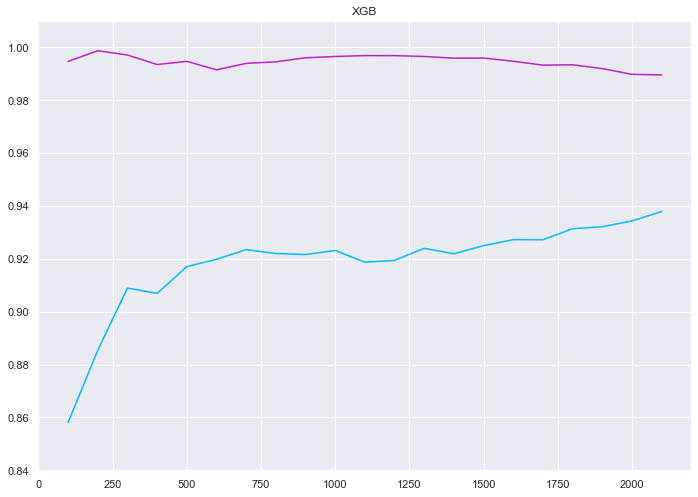

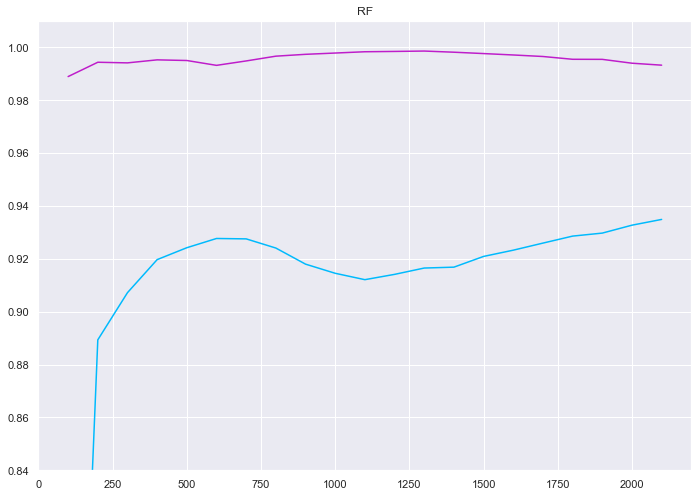

In [ ]:
models = {'XGB': best_xgb, 'RF': best_forest}
for model in models:
    train_sizes, train_scores, validation_scores = learning_curve(estimator = models[model], 
                                                X = X_new, y = y, train_sizes = range(100, 2200, 100), 
                                                cv = 6, scoring = 'f1')

    plt.plot(train_sizes, train_scores.mean(axis=1), label = 'Training error', color=colors[0])
    plt.plot(train_sizes, validation_scores.mean(axis=1), label = 'Validation error', color=colors[1])
    plt.yticks(np.arange(0.84, 1, 0.02))
    plt.ylim([0.84, 1.01])
    plt.title(model)
    plt.show()

**The plots show that the quality of the models can be improved by expanding the dataset. However, the project goals have already been achieved with minimal resources.**
**The quality of the models is relatively the same, so let's choose XGBoost.**

Из графиков видно, что качество моделей можно улучшить расширением датасета. Однако цели проекта уже достигнуты при минимальных затратах ресурсов.  
Качество моделей сравнительно одинаковое, поэтому выбремем XGBoost.

# 5. Export

In [ ]:
final_model = xgb.XGBClassifier(**searcher.best_params_)
final_model.fit(X_new, y)

XGBClassifier(alpha=0.042169650342858224, base_score=0.5, booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.2,
              enable_categorical=False, gamma=0.7498942093324559, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              lambda=0.5623413251903491, learning_rate=0.046415888336127774,
              max_delta_step=0, max_depth=2, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, num_rounds=510, predictor='auto',
              random_state=0, reg_alpha=0.0421696492, reg_lambda=0.562341332,
              scale_pos_weight=1, subsample=0.6000000000000001,
              tree_method='exact', validate_parameters=1, ...)

In [ ]:
# export final model
filename = 'insta_model.sav'
pickle.dump(final_model, open(filename, 'wb'))

In [ ]:
# export tfidf
from joblib import dump

with open('vect_user_names.pk', 'wb') as fin:
    dump(tfidf_user_names, fin)
with open('vect_posts.pk', 'wb') as fin:
    dump(tfidf_posts, fin)
with open('vect_bios.pk', 'wb') as fin:
    dump(tfidf_bios, fin)
with open('vect_full_names.pk', 'wb') as fin:
    dump(tfidf_full_name, fin)